## Prompt

We are interested in potentially opening a position on NVDA. You have been tasked with looking into the stock, and we are asking that you back up your thesis with research/stats.

Create data visualizations, and use math/stats to back up whatever your ideas are to the best of your abilities. You are free to use any libraries you want.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
nvda_prices = yf.download('NVDA', period='max')
print(nvda_prices.shape)
nvda_prices.head()

[*********************100%%**********************]  1 of 1 completed
(6204, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376288,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415709,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383456,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382261,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381067,22752000


We want to check for NULL values. It seems there are none in each column:

In [ ]:
print(nvda_prices.columns)
nvda_prices.isnull().sum()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
nvda_prices.index = pd.to_datetime(nvda_prices.index)
days_elapsed = nvda_prices.index[-1] - nvda_prices.index[0]
print(days_elapsed)

9005 days 00:00:00


First we create initial graphs to get a basic understanding of overal behavior of NVDA. We can also look at basic statistics to get an understanding of the distribution of the data.

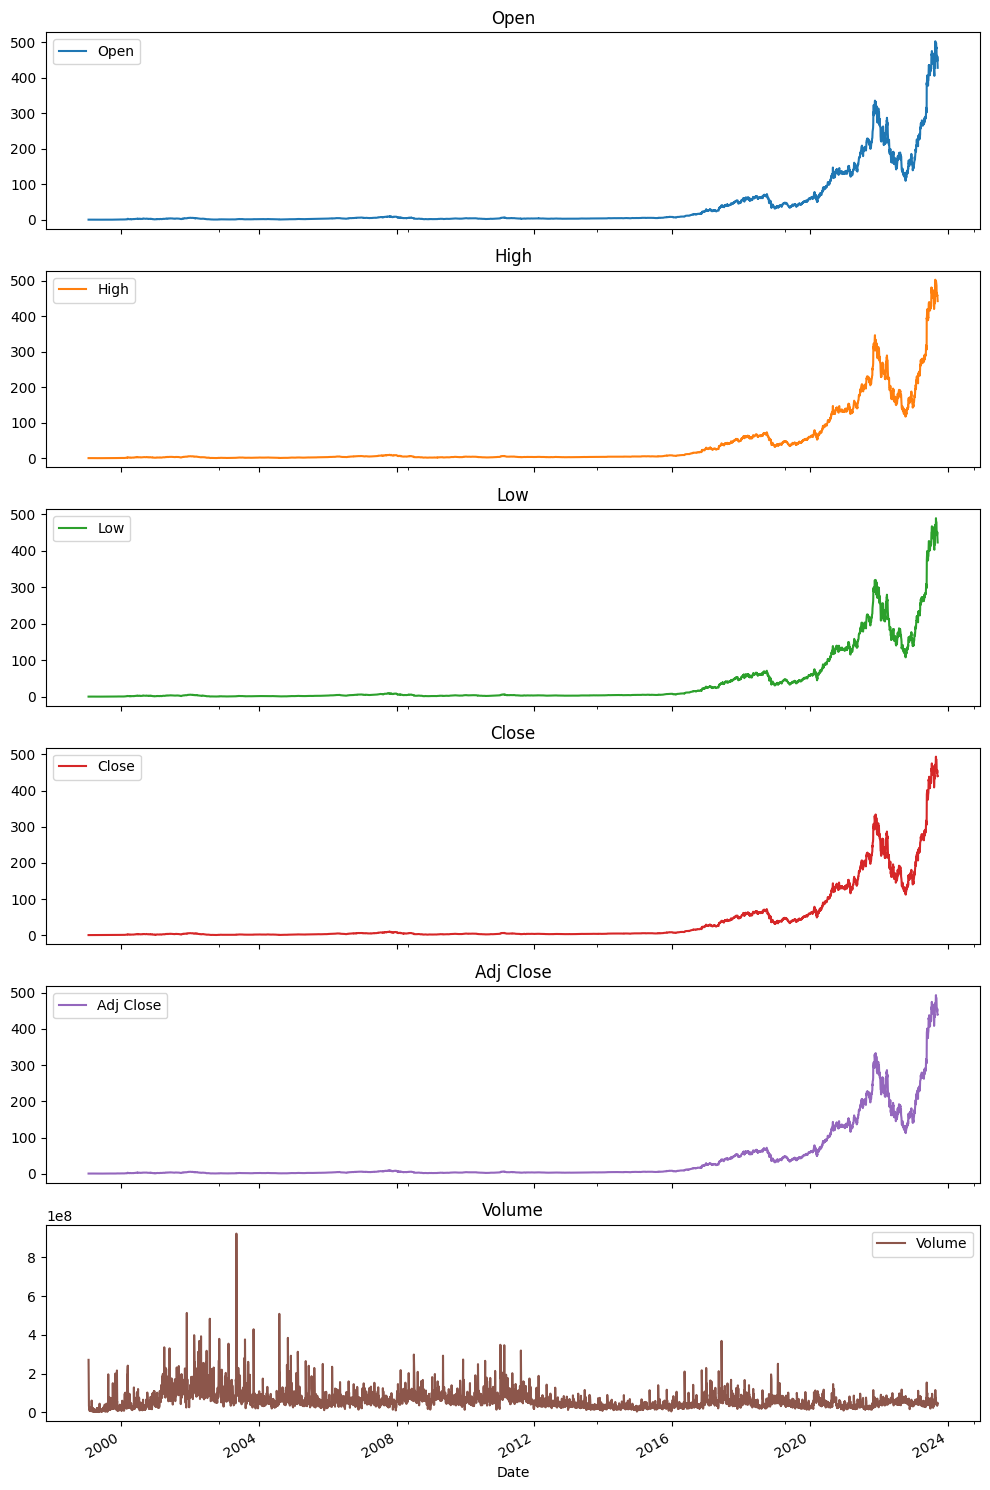

In [ ]:
axes = nvda_prices.plot(subplots=True, figsize=(10,15))

for ax, column in zip(axes, nvda_prices.columns):
    ax.set_title(column)
plt.tight_layout()
plt.show()

In [ ]:
nvda_prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6204.000000,6204.000000,6204.000000,6204.000000,6204.000000,6.204000e+03
mean,37.384178,38.087515,36.655134,37.399487,37.137098,6.117196e+07
std,76.867257,78.314068,75.317450,76.858679,76.869571,4.379638e+07
min,0.348958,0.355469,0.333333,0.341146,0.312976,1.968000e+06
25%,2.695000,2.783959,2.625000,2.702500,2.479344,3.448820e+07
50%,4.412500,4.479584,4.327500,4.407500,4.056170,5.132320e+07
75%,36.195002,36.761250,35.655625,36.175625,35.861906,7.437270e+07
max,502.160004,502.660004,489.579987,493.549988,493.509338,9.230856e+08


### Analysing Adjusted Close Price

We shall perform EDA on Adjusted Close Price first. I choose Adjusted close price because it gives a more accurate reflection of a stock's long term value, taking into account dividends, splits, etc. It is more useful for back-testing strategies as well.

Now, I want to get a basic understanging of the distributions by plotting some more detailed graphs:

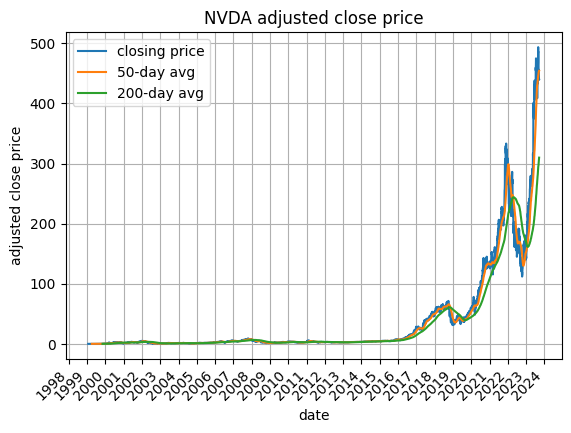

In [ ]:
nvda_prices['Adj Close'].plot(label="closing price")
nvda_prices['Adj Close'].rolling(window=50).mean().plot(label="50-day avg")
nvda_prices['Adj Close'].rolling(window=200).mean().plot(label="200-day avg")

years = mdates.YearLocator()
plt.gca().xaxis.set_major_locator(years)

# Formatting the tick to show the year only
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)


plt.title('NVDA adjusted close price')
plt.ylabel('adjusted close price')
plt.xlabel('date')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
nvda_prices["Close_Diff"] = nvda_prices["Adj Close"].diff()
monthly_avg_diff = nvda_prices['Close_Diff'].resample('M').mean()

monthly_avg_diff_change = monthly_avg_diff.diff()

# rank the top months based on these differences
top_month_diffs = monthly_avg_diff_change.nlargest(10)

print(top_month_diffs)

Date
2023-05-31    4.597973
2022-05-31    4.424069
2023-01-31    3.559757
2022-07-31    3.170096
2021-10-31    3.100379
2022-02-28    2.406236
2022-10-31    2.050420
2021-08-31    1.550906
2022-03-31    1.314788
2021-06-30    1.090781
Name: Close_Diff, dtype: float64


We can see that many of the largest increases in positive behavior happened during or after 2021. In addition, many of the top months line up somewhat closely with large technicaly developements, such as the popularity of LLMs and the release of the H100. On the other hand, low months seemed to correspond with the developement of COVID-19.

However, data for this is somewhat hard to find for feature engineering. This is important to keep in mind for future analyses.

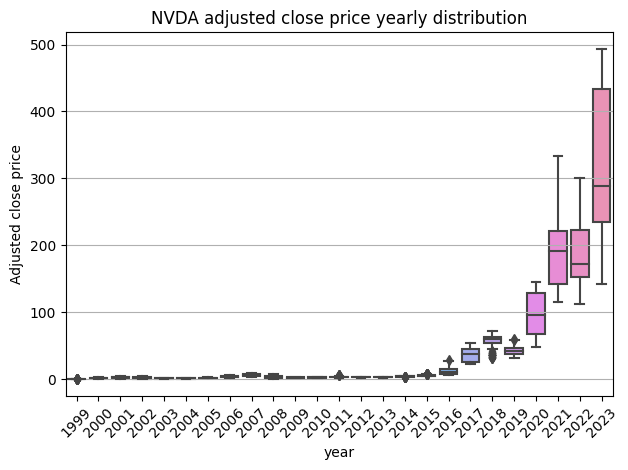

In [ ]:
# Extract the year from the Date index
nvda_prices['Year'] = nvda_prices.index.year

plt.figure()

# Create a box plot for each year
sns.boxplot(x='Year', y='Adj Close', data=nvda_prices)

plt.title('NVDA adjusted close price yearly distribution')
plt.ylabel('Adjusted close price')
plt.xlabel('year')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()

The close prices seems to start increasing/having significant outliers after 2016. This may be due to increase dewmand for gaming and AI tools. In also seems that NVDA stock continues to rise in prise despite recent inflation.

Here is an article about Nvidia's 2016 developments:
https://www.yahoo.com/now/nvidia-the-yahoo-finance-company-of-the-year-173130275.html

### Examining Returns

To get a more detailed idea of the behavior of the closing prices at specific times, I will calculate returns using the following formula:
\[\]

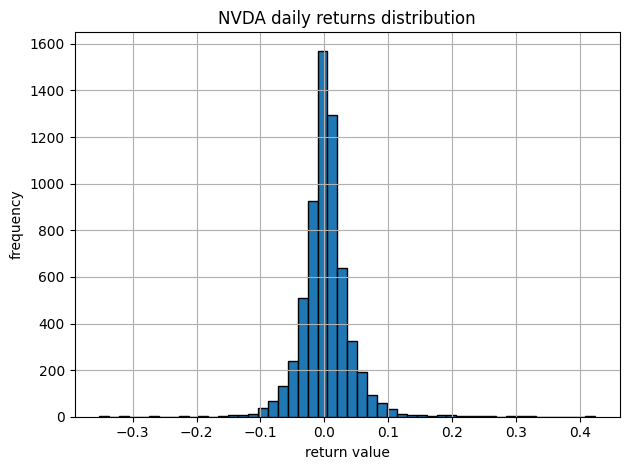

In [ ]:
nvda_prices['Returns'] = nvda_prices['Adj Close'].pct_change()

nvda_prices['Returns'].hist(bins=50, edgecolor='black')
plt.title('NVDA daily returns distribution')
plt.xlabel('return value')
plt.ylabel('frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

To further analyse returns, I decide to look at exponentially weight moving avergage (EWMA) of the returns column. EWMA is similar to a moving average, but it weighs recent values more.

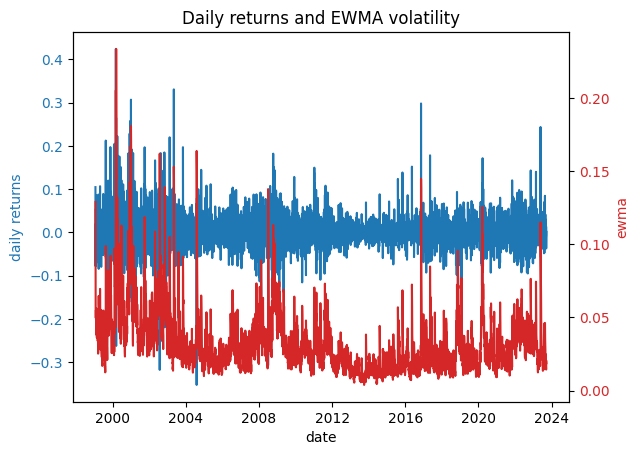

In [ ]:
# calculate 7-day EWMA
ewma_volatility = nvda_prices['Returns'].ewm(span=7).std()

fig, ax1 = plt.subplots()

# create first axis for daily returns
ax1.set_xlabel('date')
ax1.set_ylabel('daily returns', color='tab:blue')
ax1.plot(nvda_prices['Returns'].index, nvda_prices['Returns'], color='tab:blue', label='Daily Returns')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# create second axis for ewma
ax2 = ax1.twinx()
ax2.set_ylabel('ewma', color='tab:red')
ax2.plot(ewma_volatility.index, ewma_volatility, color='tab:red', label='EWMA Volatility')
ax2.tick_params(axis='y', labelcolor='tab:red')


plt.title('Daily returns and EWMA volatility')
plt.show()


In [ ]:
# Group by year and month to get monthly average
monthly_avg_volatility = ewma_volatility.groupby([ewma_volatility.index.year, ewma_volatility.index.month]).mean()
ranked_months = monthly_avg_volatility.sort_values(ascending=False)

ranked_months.head()

Date  Date
2000  3       0.121209
2001  1       0.107199
2000  12      0.105545
      4       0.093901
1999  1       0.083293
Name: Returns, dtype: float64

Ranking months reveals that the highest volatility occured early in the company's lifetime. This was most likely due to speculative trading. Volatility seems to have reduced from 2012-2016, as seen in the EWMA graph. However, volatility seems to be increasing again. Most likely due to the rise of prominence of NVDA, as well as competitors that have come up (e.g. Google, Juniper, etc.)

In [ ]:
# Filter into last 4 years
end_year = ewma_volatility.index[-1].year
start_year = end_year - 4
filtered_data = ewma_volatility[ewma_volatility.index.year >= start_year]

monthly_volatility = filtered_data.groupby([filtered_data.index.year, filtered_data.index.month]).mean()
ranked_months = monthly_volatility.sort_values(ascending=False)

ranked_months.head()

Date  Date
2020  3       0.078172
2022  5       0.052388
2020  4       0.048218
2022  2       0.045795
      3       0.043777
Name: Returns, dtype: float64

Start of COVID-19 lockdowns seem to be a significant period of volatility.

### Volume

I want to perform time series decomposition on the Volume data too see if there are any seasonal effects.

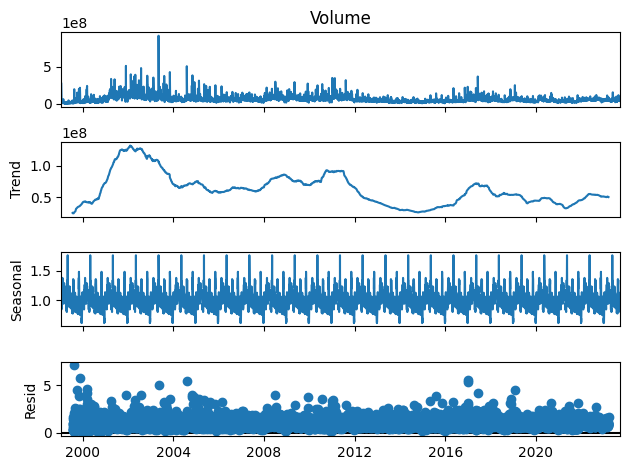

In [ ]:
result = seasonal_decompose(nvda_prices['Volume'], model='multiplicative', period=252) # 252 days of trading in a year
result.plot()
plt.show()

In [ ]:
seasonal_val = result.seasonal

# Rank dates with highest seasonal component
ranked_seasonal = seasonal_val.sort_values(ascending=False)
ranked_seasonal.head(10)

Date
2005-05-10    1.756079
2021-05-17    1.756079
2012-05-10    1.756079
2020-05-15    1.756079
2004-05-10    1.756079
2014-05-14    1.756079
2000-05-03    1.756079
2019-05-16    1.756079
1999-05-05    1.756079
2011-05-11    1.756079
Name: seasonal, dtype: float64

Season is highest in May, potentially relating to quarterly reports, which are released at Nvidia usually around the end of April.

## Feature Engineering

* Create relevant features for your models.
* Justify your choice of why these features are important. *italicized text*

Let's take a look at volume, which is a feature already in the data.

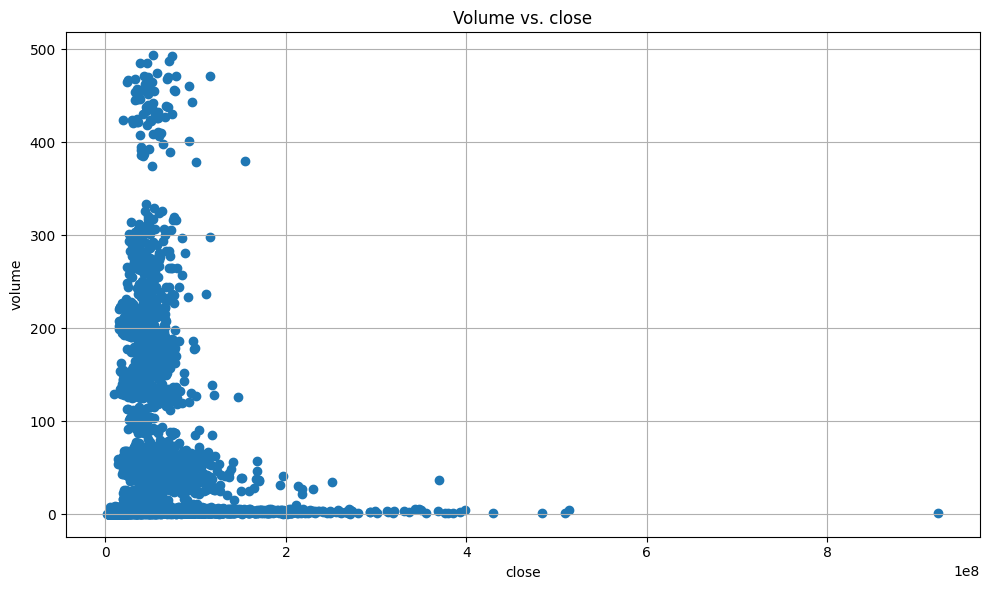

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(nvda_prices['Volume'], nvda_prices['Adj Close'])  # alpha is added to better visualize overlapping points

plt.title('Volume vs. close')
plt.xlabel('close')
plt.ylabel('volume')
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
correlation = nvda_prices['Adj Close'].corr(nvda_prices['Volume'])
print(f"Correlation coefficient: {correlation:.2f}")

Correlation coefficient: -0.13


Correlation coefficient is relatively low, so it may not be useful. However, it may be useful to look incorporate yearly cycles into our features, since we saw recurring patterns in tradings via volume. I first create a new feature dataframe.

In [ ]:
if 'Date' in nvda_prices.columns:
    nvda_prices.set_index('date', inplace=True)

# Only copying close prices and returns into feature df
feature_df = pd.DataFrame({
    'close': nvda_prices['Adj Close'],
    'returns': nvda_prices["Returns"]
})
feature_df.dropna(inplace=True)


In [ ]:
feature_df.head()

,close,returns
Date,,
1999-01-25,0.415709,0.104763
1999-01-26,0.383456,-0.077586
1999-01-27,0.382261,-0.003115
1999-01-28,0.381067,-0.003125
1999-01-29,0.363147,-0.047024


Adding features relating to date as discussed.

In [ ]:
feature_df['year'] = feature_df.index.year
feature_df['month'] = feature_df.index.month
feature_df['day_of_month'] = feature_df.index.day
feature_df['day_of_week'] = feature_df.index.dayofweek
feature_df['day_of_year'] = feature_df.index.dayofyear
feature_df['is_quarter_end'] = feature_df.index.is_quarter_end
feature_df['is_quarter_start'] = feature_df.index.is_quarter_start

In [ ]:
feature_df.head()

,close,returns,year,month,day_of_month,day_of_week,day_of_year,is_quarter_end,is_quarter_start
Date,,,,,,,,,
1999-01-25,0.415709,0.104763,1999,1,25,0,25,False,False
1999-01-26,0.383456,-0.077586,1999,1,26,1,26,False,False
1999-01-27,0.382261,-0.003115,1999,1,27,2,27,False,False
1999-01-28,0.381067,-0.003125,1999,1,28,3,28,False,False
1999-01-29,0.363147,-0.047024,1999,1,29,4,29,False,False


Next, we take a look at EWMA for close price. We say during EDA that much of NVDA's growth and fluctuation has happened in the last ~6 years. Thus, EWMA, which weights recent changes higher, is extremely important for forecasting.

In [ ]:
feature_df['ewma_7'] = feature_df['close'].ewm(span=7, adjust=False).mean()
feature_df['ewma_50'] = feature_df['close'].ewm(span=50, adjust=False).mean()
feature_df['ewma_100'] = feature_df['close'].ewm(span=100, adjust=False).mean()

feature_df['price_above_ewma_7'] = (feature_df['close'] > feature_df['ewma_7']).astype(int)
feature_df['price_above_ewma_50'] = (feature_df['close'] > feature_df['ewma_50']).astype(int)
feature_df['price_above_ewma_100'] = (feature_df['close'] > feature_df['ewma_100']).astype(int)

feature_df['price_below_ewma_7'] = (feature_df['close'] < feature_df['ewma_7']).astype(int)
feature_df['price_below_ewma_50'] = (feature_df['close'] < feature_df['ewma_50']).astype(int)
feature_df['price_below_ewma_100'] = (feature_df['close'] < feature_df['ewma_100']).astype(int)

feature_df['ewma_7_above_ewma_50'] = (feature_df['ewma_7'] > feature_df['ewma_50']).astype(int)
feature_df['ewma_7_above_ewma_100'] = (feature_df['ewma_7'] > feature_df['ewma_100']).astype(int)

feature_df['ewma_7_below_ewma_50'] = (feature_df['ewma_7'] < feature_df['ewma_50']).astype(int)
feature_df['ewma_7_below_ewma_100'] = (feature_df['ewma_7'] < feature_df['ewma_100']).astype(int)


Next, we incorporate another common indicator, which is the MACD. This indicator models momentum of a stock by taking a difference of a short-term and long-term EWMA. The EWMA of this statistic is called the signal_line, and it can help us figure out the potential direction the stock will move.

In [ ]:
short_ewma = feature_df['close'].ewm(span=12, adjust=False).mean()
long_ewma = feature_df['close'].ewm(span=26, adjust=False).mean()
feature_df['macd'] = short_ewma - long_ewma

# signal line
feature_df['signal_line'] = feature_df['macd'].ewm(span=9, adjust=False).mean()

# add features relating macd to signal line
feature_df['macd_above_signal'] = (feature_df['macd'] > feature_df['signal_line']).astype(int)
feature_df['macd_below_signal'] = (feature_df['macd'] < feature_df['signal_line']).astype(int)


In [ ]:
feature_df.tail(20)

,close,returns,year,month,day_of_month,day_of_week,day_of_year,is_quarter_end,is_quarter_start,ewma_7,...,price_below_ewma_50,price_below_ewma_100,ewma_7_above_ewma_50,ewma_7_above_ewma_100,ewma_7_below_ewma_50,ewma_7_below_ewma_100,macd,signal_line,macd_above_signal,macd_below_signal
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-21,469.631317,0.084713,2023,8,21,0,233,False,False,442.944162,...,0,0,1,1,0,0,1.682298,1.882765,0,1
2023-08-22,456.642365,-0.027658,2023,8,22,1,234,False,False,446.368713,...,0,0,1,1,0,0,2.750275,2.056267,1,0
2023-08-23,471.121185,0.031707,2023,8,23,2,235,False,False,452.556831,...,0,0,1,1,0,0,4.710673,2.587148,1,0
2023-08-24,471.591156,0.000998,2023,8,24,3,236,False,False,457.315412,...,0,0,1,1,0,0,6.230405,3.315799,1,0
2023-08-25,460.142090,-0.024278,2023,8,25,4,237,False,False,458.022082,...,0,0,1,1,0,0,6.436760,3.939992,1,0
2023-08-28,468.311432,0.017754,2023,8,28,0,240,False,False,460.594419,...,0,0,1,1,0,0,7.176767,4.587347,1,0
2023-08-29,487.799805,0.041614,2023,8,29,1,241,False,False,467.395766,...,0,0,1,1,0,0,9.229386,5.515754,1,0
2023-08-30,492.599426,0.009839,2023,8,30,2,242,False,False,473.696681,...,0,0,1,1,0,0,11.115260,6.635656,1,0
2023-08-31,493.509338,0.001847,2023,8,31,3,243,False,False,478.649845,...,0,0,1,1,0,0,12.538713,7.816267,1,0


Including Bollinger bands is also important, as they can tell us about stock volatility. We saw in the previous analysis that volatility started high, had a low period, and is now increasing once again. Bollinger bands can help us utilize this type of pattern to predict volatility and behavior in the future.

In [ ]:
# Small window size
window = 20
num_std = 2

rolling_mean = feature_df['close'].rolling(window=window).mean()
rolling_std = feature_df['close'].rolling(window=window).std()

# We set bounds to 2 stdevs away
feature_df['upper_bollinger'] = rolling_mean + (rolling_std * num_std)
feature_df['lower_bollinger'] = rolling_mean - (rolling_std * num_std)

feature_df['close_minus_upper_bollinger'] = feature_df['close'] - feature_df['upper_bollinger']
feature_df['close_minus_lower_bollinger'] = feature_df['close'] - feature_df['lower_bollinger']


In [ ]:
feature_df.tail(20)

,close,returns,year,month,day_of_month,day_of_week,day_of_year,is_quarter_end,is_quarter_start,ewma_7,...,ewma_7_below_ewma_50,ewma_7_below_ewma_100,macd,signal_line,macd_above_signal,macd_below_signal,upper_bollinger,lower_bollinger,close_minus_upper_bollinger,close_minus_lower_bollinger
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-21,469.631317,0.084713,2023,8,21,0,233,False,False,442.944162,...,0,0,1.682298,1.882765,0,1,478.462370,412.612218,-8.831053,57.019099
2023-08-22,456.642365,-0.027658,2023,8,22,1,234,False,False,446.368713,...,0,0,2.750275,2.056267,1,0,478.449016,412.614571,-21.806651,44.027794
2023-08-23,471.121185,0.031707,2023,8,23,2,235,False,False,452.556831,...,0,0,4.710673,2.587148,1,0,481.028103,411.699348,-9.906918,59.421838
2023-08-24,471.591156,0.000998,2023,8,24,3,236,False,False,457.315412,...,0,0,6.230405,3.315799,1,0,483.057745,410.932602,-11.466589,60.658554
2023-08-25,460.142090,-0.024278,2023,8,25,4,237,False,False,458.022082,...,0,0,6.436760,3.939992,1,0,481.958365,411.300042,-21.816275,48.842047
2023-08-28,468.311432,0.017754,2023,8,28,0,240,False,False,460.594419,...,0,0,7.176767,4.587347,1,0,482.144539,411.219859,-13.833107,57.091573
2023-08-29,487.799805,0.041614,2023,8,29,1,241,False,False,467.395766,...,0,0,9.229386,5.515754,1,0,487.027282,408.613926,0.772522,79.185879
2023-08-30,492.599426,0.009839,2023,8,30,2,242,False,False,473.696681,...,0,0,11.115260,6.635656,1,0,494.220283,406.415514,-1.620857,86.183912
2023-08-31,493.509338,0.001847,2023,8,31,3,243,False,False,478.649845,...,0,0,12.538713,7.816267,1,0,500.589546,404.885854,-7.080207,88.623484


Next, we add lagging features for previous close prices. N=20 days

In [ ]:
for i in range(1, 21):
    col_name = f'lagging_close_{i}'
    feature_df[col_name] = feature_df['close'].shift(i)

## Predictive Modeling

* Create a model to forecast prices.
* Evaluate your model performance.
* Discuss pros/cons of the models you used.

In [ ]:
feature_df.head()

,close,returns,year,month,day_of_month,day_of_week,day_of_year,is_quarter_end,is_quarter_start,ewma_7,...,lagging_close_11,lagging_close_12,lagging_close_13,lagging_close_14,lagging_close_15,lagging_close_16,lagging_close_17,lagging_close_18,lagging_close_19,lagging_close_20
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-25,0.415709,0.104763,1999,1,25,0,25,False,False,0.415709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-26,0.383456,-0.077586,1999,1,26,1,26,False,False,0.407645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-27,0.382261,-0.003115,1999,1,27,2,27,False,False,0.401299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-28,0.381067,-0.003125,1999,1,28,3,28,False,False,0.396241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-29,0.363147,-0.047024,1999,1,29,4,29,False,False,0.387968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X = feature_df.drop('close', axis=1)
y = feature_df['close']

First I want to train a Light Gradient Boosting Model. It has fast training speeds and requires minimal compute. I first complete simple hyperparameter tuning on the model.

In [ ]:
# hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5, 10]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

best_score = float('inf')
best_params = {}

# Grid search for hyperparameter tuning
for params in ParameterGrid(param_grid):
    model = lgb.LGBMRegressor(**params)#, verbose=-1)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    score = mean_squared_error(y_test, predictions)

    if score < best_score:
        best_score = score
        best_params = params

print("Best Params: " + str(best_params))
print("MSE: " + str(best_score))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7998
[LightGBM] [Info] Number of data points in the train set: 4961, number of used features: 49
[LightGBM] [Info] Start training from score 7.643043
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7998
[LightGBM] [Info] Number of data points in the train set: 4961, number of used features: 49
[LightGBM] [Info] Start training from score 7.643043
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

I know create a method for training and testing the model at various points in our time series.

In [ ]:
def train_and_predict(data, end_date, best_params):
    # filter data to specific end date
    end_date = pd.Timestamp(end_date)
    train = data[data.index <= end_date]
    test = data[(data.index > end_date) & (data.index <= end_date + pd.Timedelta('200 days'))] # We are forecasting for 200 days

    X_train = train.drop('close', axis=1)
    y_train = train['close']
    X_test = test.drop('close', axis=1)

    # train model with best_params
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    # cut down test_values in some cases where there is missing data
    min_length = min(len(predictions), len(test['close']))
    preds = predictions[:min_length]
    test_values = test['close'].values[:min_length]

    # return test timestamp and corresponding prediction, as well as mse and correlation
    test_dates = test.index[:min_length]
    mse = mean_squared_error(test_values, predictions)
    correlation = np.corrcoef(test_values, predictions)[0, 1]

    return test_dates, preds, mse, correlation

In [ ]:
dates_to_predict = ['2016-01-01', '2020-01-01', '2023-01-01', "2021-10-01", "2018-08-01"]

all_predictions = {}
all_mse = {}
all_correlations = {}

for date in dates_to_predict:
    test_dates, preds, mse, corr = train_and_predict(feature_df, str(date), best_params)
    all_predictions[date] = (test_dates, preds)
    all_mse[date] = mse
    all_correlations[date] = corr

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7993
[LightGBM] [Info] Number of data points in the train set: 4263, number of used features: 49
[LightGBM] [Info] Start training from score 3.134489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

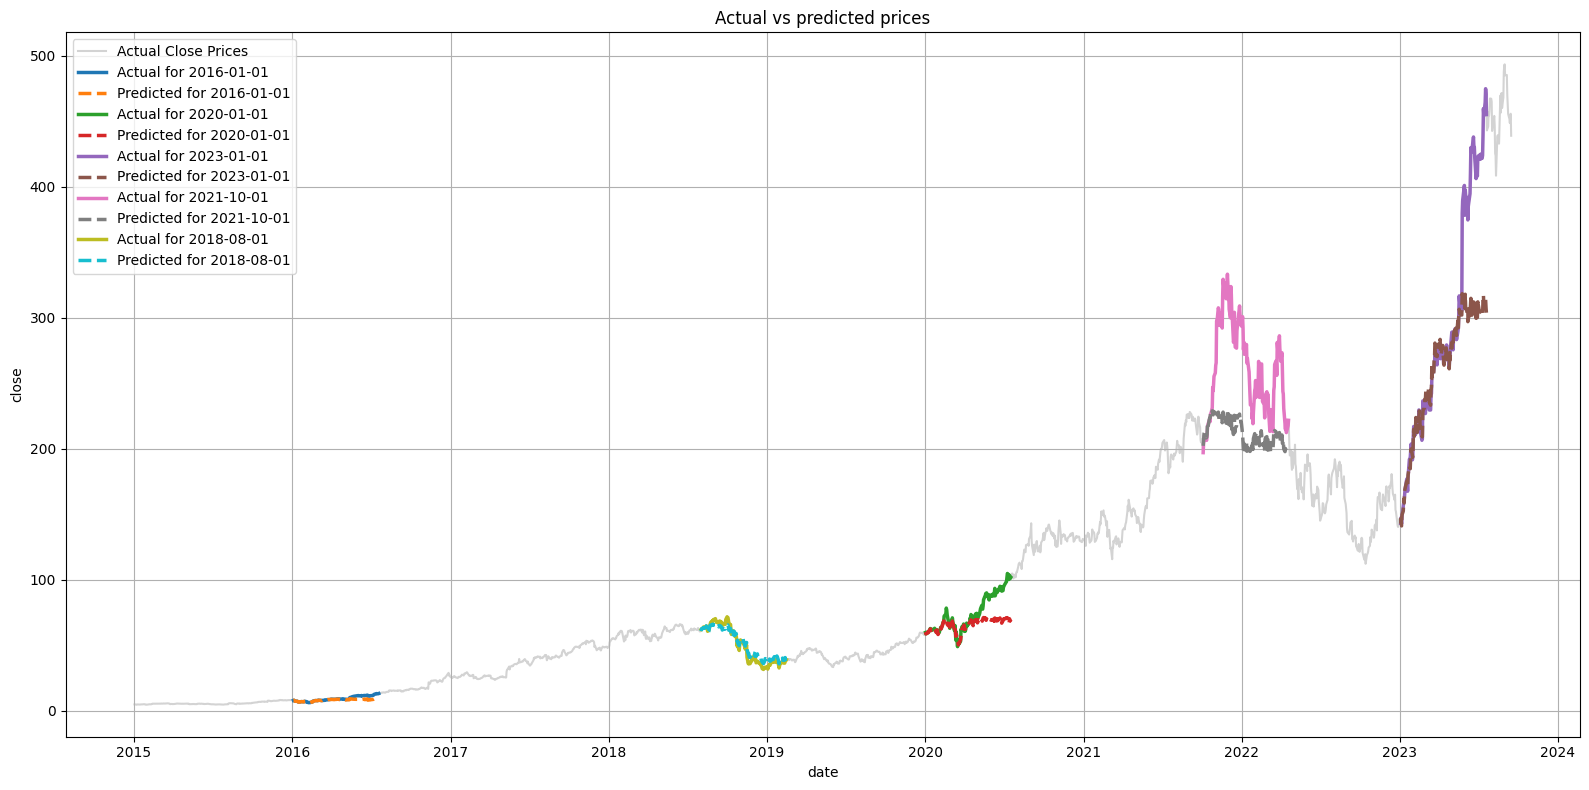

In [ ]:
# Only plot from after 2014
filtered_df = feature_df[feature_df.index.year > 2014]

plt.figure(figsize=(16, 8))

plt.plot(filtered_df.index, filtered_df['close'], label='Actual Close Prices', color='lightgray', zorder=1)

# plotting predictions and actual values for the specific dates
for date, (test_dates, preds) in all_predictions.items():
  plt.plot(test_dates, filtered_df.loc[test_dates, 'close'], label=f"Actual for {date}", linewidth=2.5, zorder=2)
  plt.plot(test_dates, preds, linestyle='--', label=f"Predicted for {date}", linewidth=2.5, zorder=3)

plt.title("Actual vs predicted prices")
plt.xlabel("date")
plt.ylabel("close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


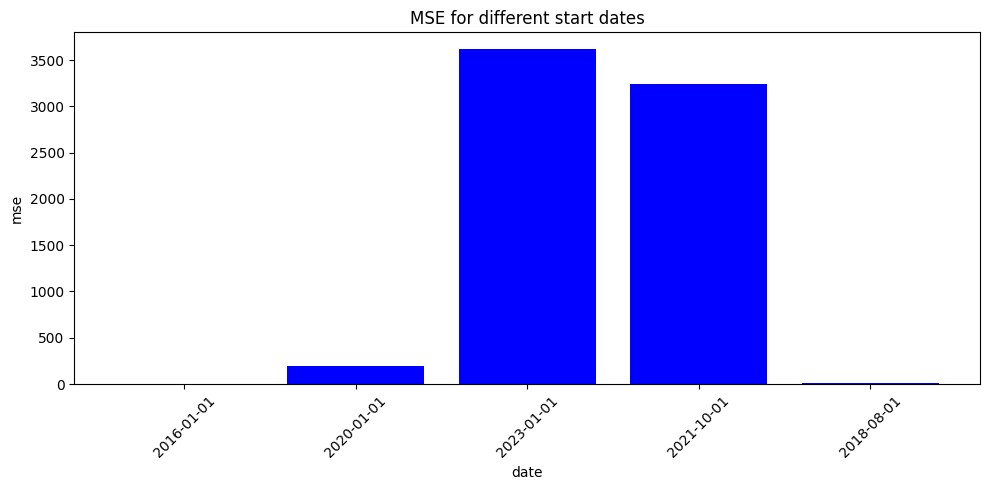

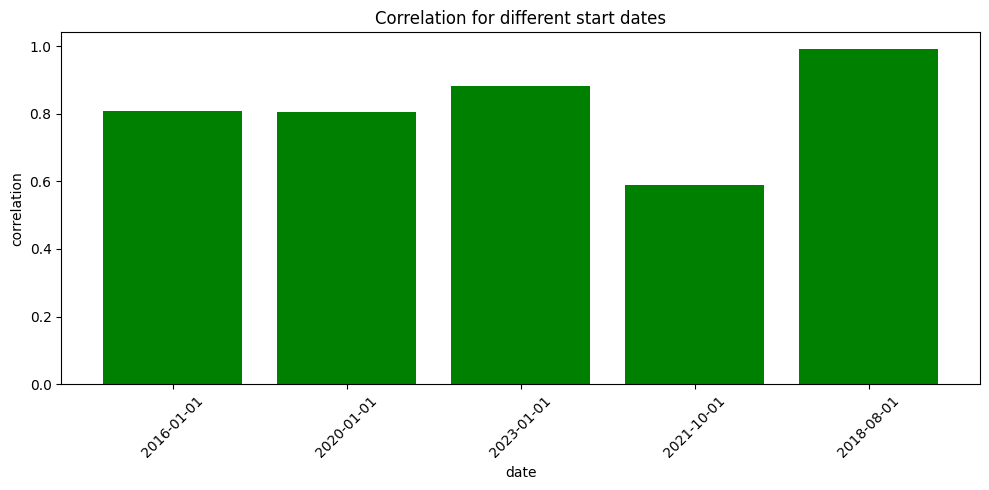

In [ ]:
# plotting MSE
plt.figure(figsize=(10, 5))
plt.bar(all_mse.keys(), all_mse.values(), color='blue')
plt.title('MSE for different start dates')
plt.xlabel('date')
plt.ylabel('mse')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Correlation
plt.figure(figsize=(10, 5))
plt.bar(all_correlations.keys(), all_correlations.values(), color='green')
plt.title('Correlation for different start dates')
plt.xlabel('date')
plt.ylabel('correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


I will now sort the top features to get a better understanding of how the model is making it's decisions

In [ ]:
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# get feature importances and rank
importances = model.feature_importances_
feature_df_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

sorted_feature_df = feature_df_importances.sort_values(by='importance', ascending=False)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7998
[LightGBM] [Info] Number of data points in the train set: 4961, number of used features: 49
[LightGBM] [Info] Start training from score 7.643043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

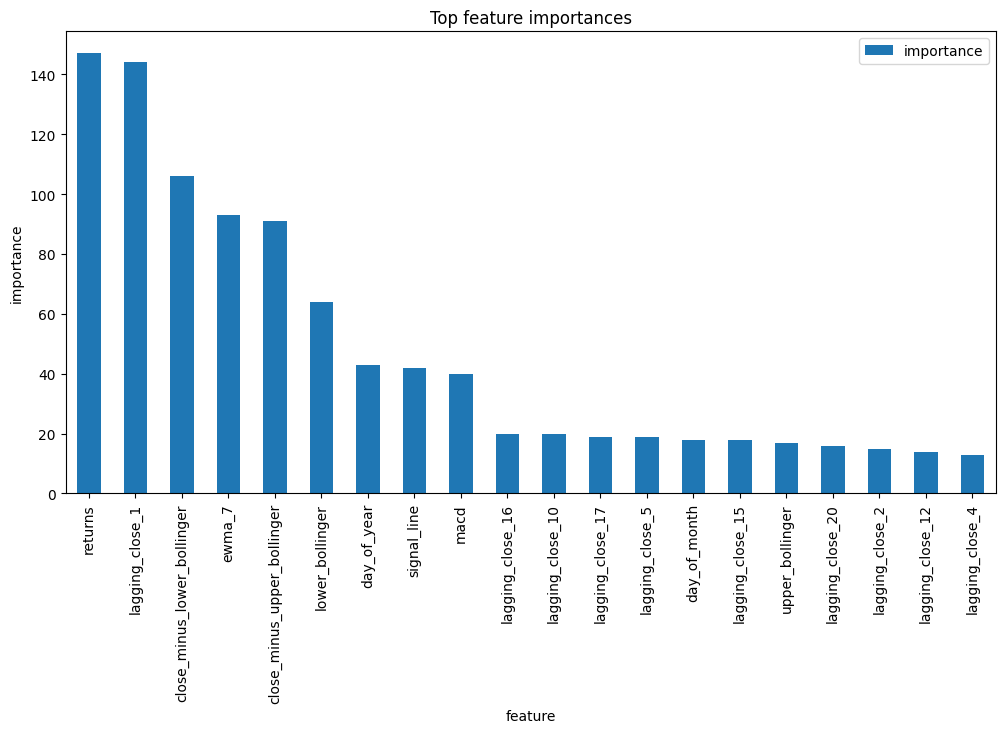

In [ ]:
sorted_feature_df.head(20).plot(kind='bar', x='feature', y='importance', figsize=(12, 6))
plt.title('Top feature importances')
plt.ylabel('importance')
plt.show()

Naturally, the lagging close values are significant in influences the models decision. In addition, it seems that EWMA_7, as well as the bollinger bands are useful for prediciton

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(feature_df['close'].values.reshape(-1, 1))

# function to format data for lstm
def create_dataset(dataset, time_step=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#X, y = create_dataset(scaled_data, 20)
#X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
#model.fit(X, y, batch_size=1, epochs=10, validation_split=0.2)

In [ ]:
def lstm_train_and_predict(data, end_date):
    # filter data to specific end date
    end_date = pd.Timestamp(end_date)
    train = data[data.index <= end_date]
    test = data[(data.index > end_date) & (data.index <= end_date + pd.Timedelta('200 days'))]

    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train['close'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['close'].values.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled)
    X_test, y_test = create_dataset(test_scaled)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # create simple lstm architecture
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    #
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # handle length mismatch
    min_length = min(len(predictions), len(test['close']))
    preds = predictions[:min_length].flatten()
    test_values = test['close'].values[:min_length]

    test_dates = test.index[:min_length]
    mse = mean_squared_error(test_values, preds)
    correlation = np.corrcoef(test_values, preds)[0, 1]

    return test_dates, preds, mse, correlation


In [ ]:
dates_to_predict = ['2016-01-01', '2020-01-01', '2023-01-01', "2021-10-01", "2018-08-01"]

all_predictions = {}
all_mse = {}
all_correlations = {}

for date in dates_to_predict:
    test_dates, preds, mse, corr = lstm_train_and_predict(feature_df, date)
    all_predictions[date] = (test_dates, preds)
    all_mse[date] = mse
    all_correlations[date] = corr

Epoch 1/10
133/133 [==============================] - 12s 16ms/step - loss: 0.0056 - val_loss: 0.0072
Epoch 2/10
133/133 [==============================] - 1s 9ms/step - loss: 8.3287e-04 - val_loss: 0.0047
Epoch 3/10
133/133 [==============================] - 1s 7ms/step - loss: 7.3121e-04 - val_loss: 0.0042
Epoch 4/10
133/133 [==============================] - 1s 7ms/step - loss: 6.2592e-04 - val_loss: 0.0038
Epoch 5/10
133/133 [==============================] - 1s 7ms/step - loss: 5.3567e-04 - val_loss: 0.0026
Epoch 6/10
133/133 [==============================] - 1s 7ms/step - loss: 5.0407e-04 - val_loss: 0.0020
Epoch 7/10
133/133 [==============================] - 1s 7ms/step - loss: 4.8263e-04 - val_loss: 0.0064
Epoch 8/10
133/133 [==============================] - 1s 7ms/step - loss: 4.4205e-04 - val_loss: 0.0018
Epoch 9/10
133/133 [==============================] - 1s 7ms/step - loss: 4.1740e-04 - val_loss: 0.0013
Epoch 10/10
4/4 [==============================] - 1s 5ms/step
Epo

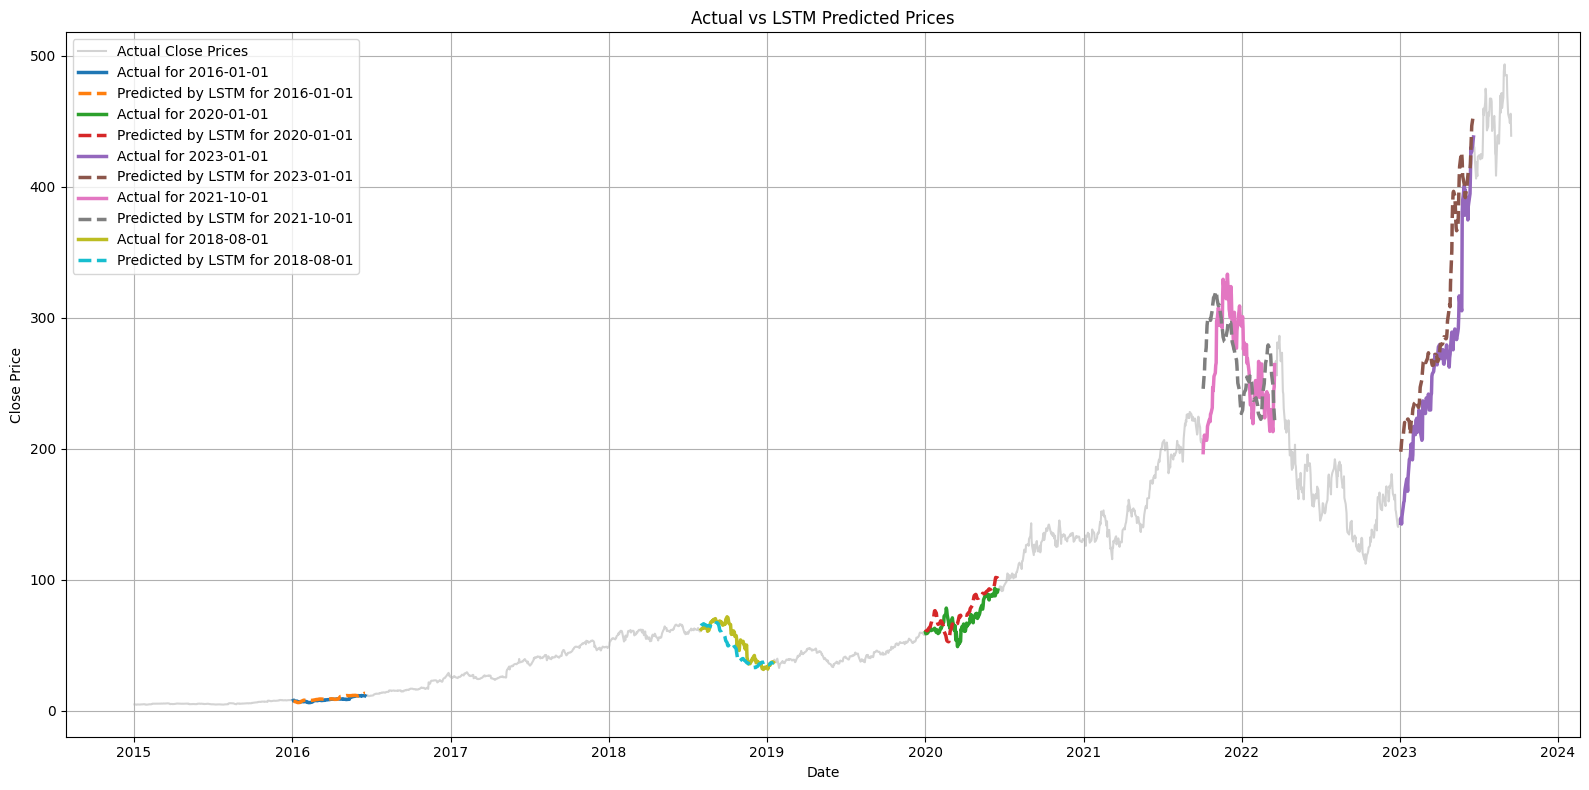

In [ ]:
# Only plot data from after 2014
filtered_df = feature_df[feature_df.index.year > 2014]

plt.figure(figsize=(16, 8))

# Plot the original close prices
plt.plot(filtered_df.index, filtered_df['close'], label='Actual Close Prices', color='lightgray', zorder=1)

# plotting predictions and actual values for the specific dates using LSTM predictions
for date, (test_dates, preds) in all_predictions.items():
    plt.plot(test_dates, filtered_df.loc[test_dates, 'close'], label=f"Actual for {date}", linewidth=2.5, zorder=2)
    plt.plot(test_dates, preds, linestyle='--', label=f"Predicted by LSTM for {date}", linewidth=2.5, zorder=3)

plt.title("Actual vs LSTM Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


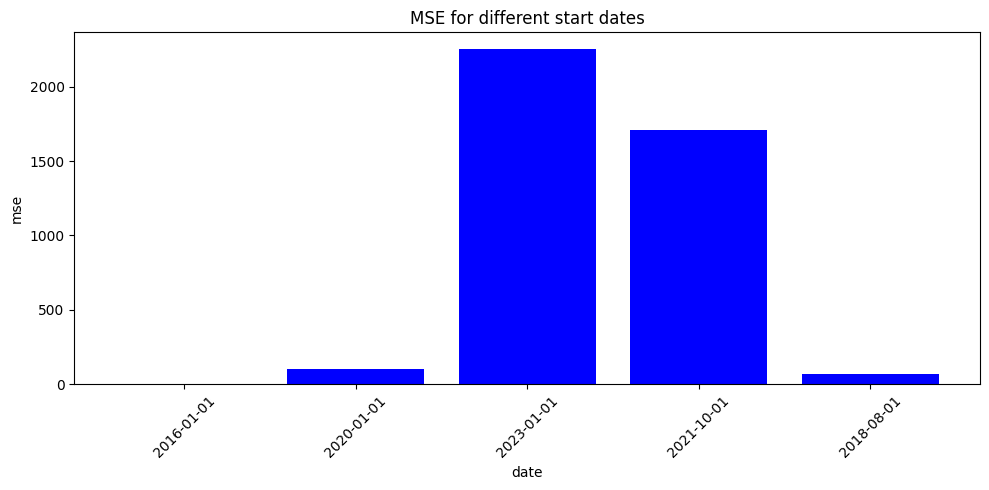

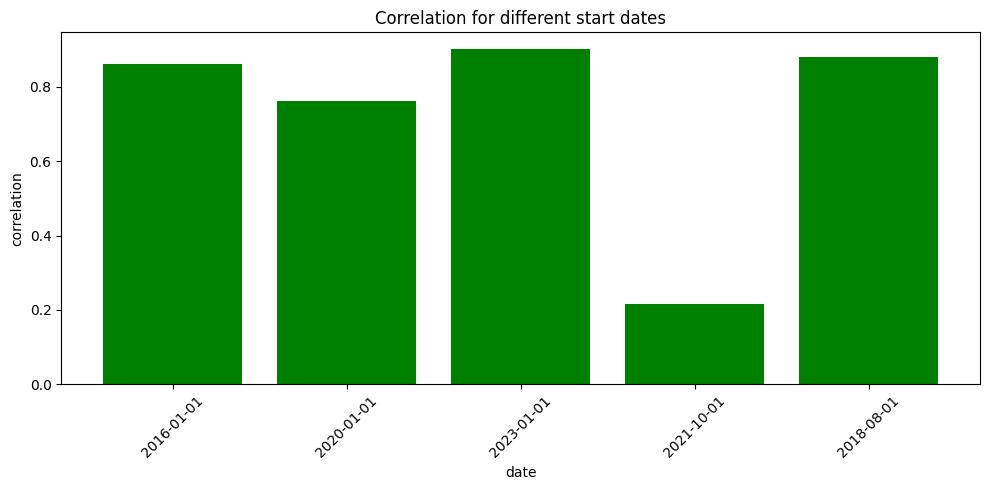

In [ ]:
# plotting MSE
plt.figure(figsize=(10, 5))
plt.bar(all_mse.keys(), all_mse.values(), color='blue')
plt.title('MSE for different start dates')
plt.xlabel('date')
plt.ylabel('mse')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Correlation
plt.figure(figsize=(10, 5))
plt.bar(all_correlations.keys(), all_correlations.values(), color='green')
plt.title('Correlation for different start dates')
plt.xlabel('date')
plt.ylabel('correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the Graphs, we can see that the LSTM model predictions are much closer to the actual values. In addition, it is creating less mean square error.

### Forecasting the Future

Now, we will replicate the LSTM training method, but this time make predictions for the next 200 days.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(feature_df['close'].values.reshape(-1, 1))

X, y = create_dataset(scaled_data, 20)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
155/155 [==============================] - 7s 13ms/step - loss: 5.6659e-05 - val_loss: 0.0012
Epoch 2/10
155/155 [==============================] - 1s 8ms/step - loss: 4.4995e-06 - val_loss: 0.0016
Epoch 3/10
155/155 [==============================] - 1s 8ms/step - loss: 5.1722e-06 - val_loss: 0.0022
Epoch 4/10
155/155 [==============================] - 1s 8ms/step - loss: 3.4047e-06 - val_loss: 0.0020
Epoch 5/10
155/155 [==============================] - 2s 12ms/step - loss: 4.4976e-06 - val_loss: 0.0041
Epoch 6/10
155/155 [==============================] - 2s 10ms/step - loss: 4.2406e-06 - val_loss: 0.0025
Epoch 7/10
155/155 [==============================] - 1s 8ms/step - loss: 3.4195e-06 - val_loss: 0.0022
Epoch 8/10
155/155 [==============================] - 1s 8ms/step - loss: 2.9237e-06 - val_loss: 0.0039
Epoch 9/10
155/155 [==============================] - 1s 9ms/step - loss: 3.6412e-06 - val_loss: 0.0023
Epoch 10/10
155/155 [==============================] - 1s 8ms

We need to keep track of a rolling window of 20 dates, so the model can guess the next one.

In [ ]:
def lstm_get_future_prediction(data, model):
    future_predictions = []

    # Get list of init most recent 20 days
    prev_window = list(data[-20:].flatten())

    for i in range(200):
        # process last 20 data points
        current_data = np.array(prev_window[-20:]).reshape(1, 20, 1)
        predicted_value = model.predict(current_data)
        future_predictions.append(predicted_value[0][0])  # Store prediction

        prev_window.append(predicted_value[0][0])

    # calculate inverse transform to fix messy predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions.flatten()


In [ ]:
future_predictions = lstm_get_future_prediction(scaled_data, model)

1/1 [==============================] - 0s 28ms/step


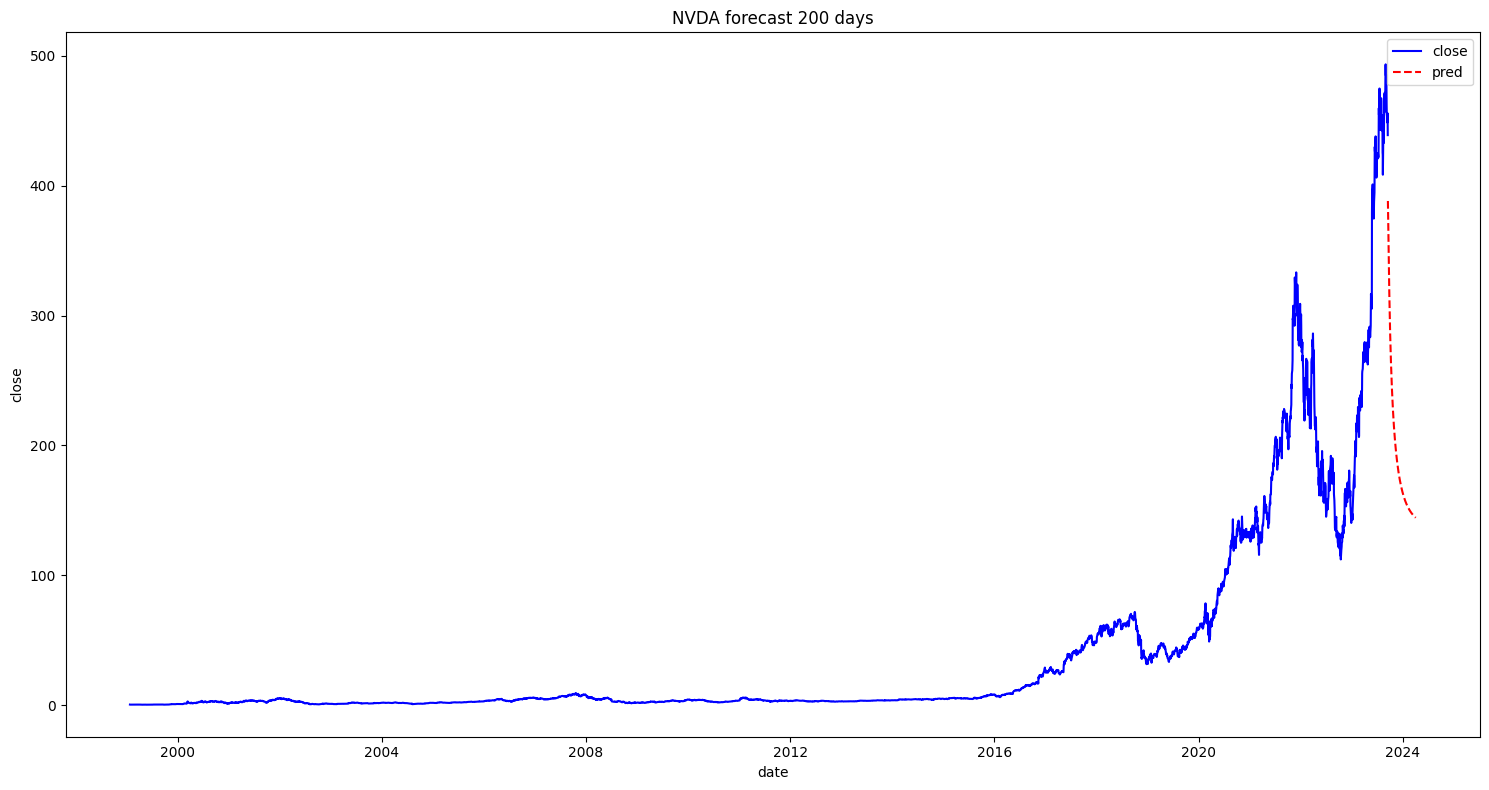

In [ ]:
last_date = feature_df.index[-1]
prediction_dates = pd.date_range(last_date + pd.Timedelta('1 day'), periods=200)

plt.figure(figsize=(15, 8))
plt.plot(feature_df.index, feature_df['close'], label='close', color='blue')
plt.plot(prediction_dates, future_predictions, label='pred', color='red', linestyle='dashed')
plt.title('NVDA forecast 200 days')
plt.xlabel('date')
plt.ylabel('close')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X = feature_df.drop('close', axis=1)
y = feature_df['close']

model = lgb.LGBMRegressor(**best_params)
model.fit(X, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8002
[LightGBM] [Info] Number of data points in the train set: 6202, number of used features: 49
[LightGBM] [Info] Start training from score 37.078132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMRegressor(max_depth=3, min_child_weight=1, n_estimators=200)

<ipython-input-49-828947660acb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(new_row)
<ipython-input-49-828947660acb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(new_row)
<ipython-input-49-828947660acb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(new_row)
<ipython-input-49-828947660acb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(new_row)
<ipython-input-49-828947660acb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df =

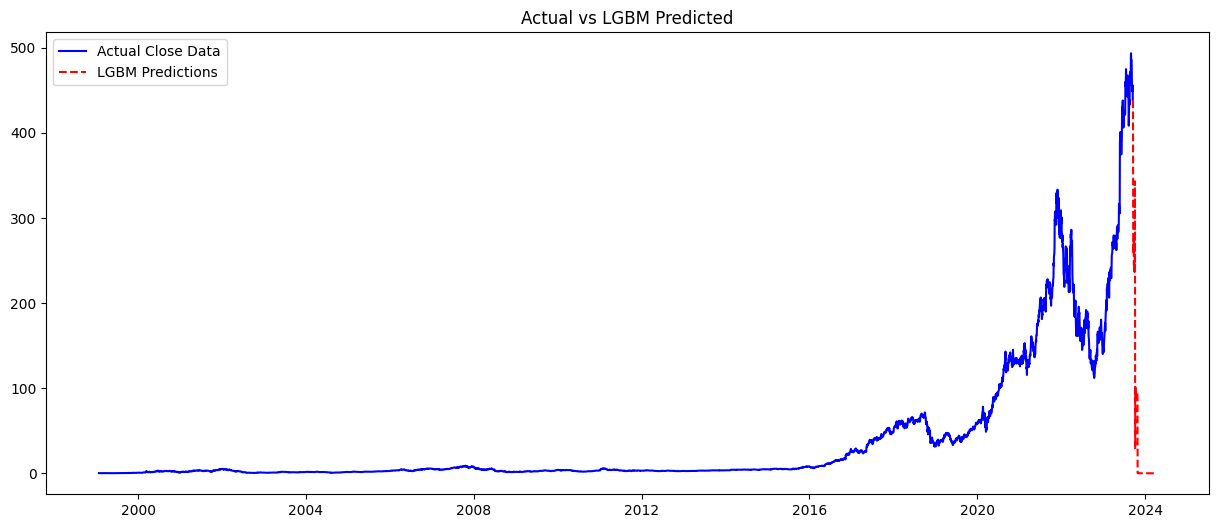

In [ ]:
def get_future_prediction_lgbm(model, feature_df, days=200):
    future_predictions = []
    temp_df = feature_df.copy()

    for i in range(days):
        last_data_point = temp_df.iloc[-1].drop('close').values.reshape(1, -1)
        prediction = model.predict(last_data_point)

        new_row = temp_df.iloc[-1].shift(-1)
        new_row['close'] = prediction[0]
        temp_df = temp_df.append(new_row)

        future_predictions.append(prediction[0])

    return future_predictions

future_predictions_lgbm = get_future_prediction_lgbm(model, feature_df)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(feature_df.index, feature_df['close'], label='close', color='blue')
plt.plot(pd.date_range(feature_df.index[-1], periods=201, closed='right'), future_predictions_lgbm, label='LGBM predictions', color='red', linestyle='dashed')
plt.title('LGBM forecast')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step


<ipython-input-52-ca6699669882>:41: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  plt.plot(pd.date_range(feature_df.index[-1], periods=201, closed='right'), future_predictions_lstm_retrain, label='LSTM Predictions', linestyle='dashed', color='red')


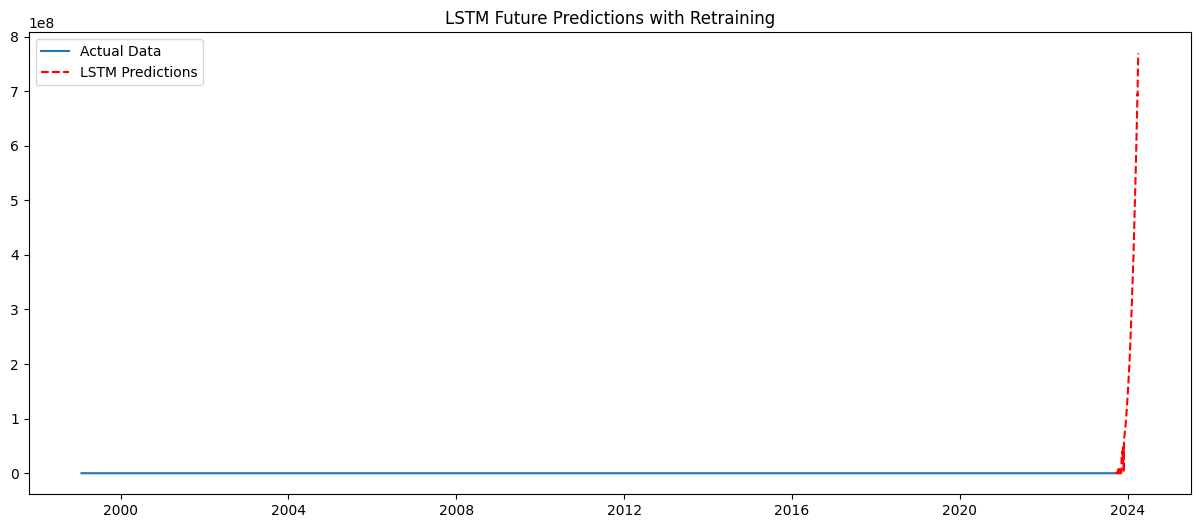

In [ ]:
def lstm_get_future_prediction_retrain(data, model):
    future_predictions = []

    for i in range(200):
        scaled_data = scaler.transform(data[-20:].reshape(-1, 1))

        current_data = scaled_data.reshape(1, 20, 1)

        predicted_value = model.predict(current_data)
        predicted_value_rescaled = scaler.inverse_transform(predicted_value)

        future_predictions.append(predicted_value_rescaled[0][0])  # Store prediction

        data = np.append(data, predicted_value_rescaled)

        X, _ = create_dataset(data[:-1].reshape(-1, 1))
        _, y = create_dataset(data[1:].reshape(-1, 1))

        X = X.reshape(X.shape[0], X.shape[1], 1) # potential error
        model.fit(X, y, epochs=10, batch_size=32, verbose=0, shuffle=False)

    return np.array(future_predictions)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(20,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

future_predictions_lstm_retrain = lstm_get_future_prediction_retrain(feature_df['close'].values, model)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(feature_df.index, feature_df['close'].values, label='Actual Data')
plt.plot(pd.date_range(feature_df.index[-1], periods=201, closed='right'), future_predictions_lstm_retrain, label='LSTM Predictions', linestyle='dashed', color='red')
plt.title('LSTM Future Predictions with Retraining')
plt.legend()
plt.show()


## Recommendation

* Justify your research.
* Insights on potential risks/uncertainties. Do you foresee any macroeconomic risks (economic turbulence, politics, etc.), or microeconomic risks (competition, bubbles, product dewmand, etc.)?

Unfortuanately, I wasn't able to get reasonable results when attempting to forecast the NVDA stocks using the LSTM model. My approach was to train the LSTM on all data points, and iteratively make daily predictions using the last 20 days. While I got very good results for past time periods, future forecasting was difficult, because any error the model had compounded on itself. There is no "test" data to guide the model. I tried to retrain the model every time as well, but this also led to bad results.

With less time constraint, I would use simplier models like ARIMA. If I were to continue the deep learning approach, I may use more models (e.g. ensemble methods) than use LGBM and use them to perform feature selection. Using the most important features, I may then get better results for LSTM forecasting. In addition, LSTM architecture optimization would be useful with more time/compute.

Despite not getting conclusive results with deep learning, the data exploration and feature engineering steps were insightful. Two major technical indicators: the MACD dropping below the singal line and the close price dropping closer to the lower Bollinger bound, may indicate overselling. This indications a temporarly break in NVDA's close price, which will reverse and continue to increase in the future. In addition, the Bollinger bounds and Return EWMA cycle inidicate that in the near future, NVDA's volatility may decrease.

Given that NVDA's stock has continues to increase despite nationwide inflation and recession, the strength of this stock is evident. In addiiton, demand will only continue to rise for Nvidia's products in the near future, as LLM development and research continues to thrive. Nvidia's competitors (eg. AMD, Juniper, etc.) haven't seen similar benefits from the popularization of LLMs/transformers, which proves NVDA's dominance in the market as of now.